In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import os
from IPython.core.display import display
from pandas.io.json import json_normalize 

In [2]:
path = "/home/mateos/snapshots"
files = sorted(os.listdir(path))
must_skip = 1
obj_all = []
for f in files:
    m = re.search(r'^log_\d{8}_\d{4}$', f)
    if not m:
        continue
    with open(path + '/' + f , 'r') as fp:
        json_str = fp.read()
        if json_str == '':
            continue
        obj = json.loads(json_str)
        obj_all += [obj]

#data = pd.DataFrame.from_dict(obj_all, orient='columns')
data = pd.DataFrame.from_dict(obj_all)

In [3]:
data['date'] = pd.to_datetime(data['date'], yearfirst=True)
data['cpu'] = data['cpu'].str.replace('%', '').astype(float)
data.head()

,cpu,date,load,n_proc,queries,top_proc
0,2.79256,2019-07-03 15:50:01,0.20 0.05 0.02 1/302 3250,165,[],"[{'pid': '61', 'cpu': '2.0', 'command': '[kswa..."
1,2.77177,2019-07-03 16:00:02,0.00 0.00 0.00 1/303 3352,166,[],"[{'pid': '61', 'cpu': '1.9', 'command': '[kswa..."
2,2.75171,2019-07-03 16:10:01,0.00 0.01 0.00 1/296 3573,162,[],"[{'pid': '30978', 'cpu': '9.6', 'command': 'py..."
3,2.73062,2019-07-03 16:20:01,0.00 0.00 0.00 1/298 3694,164,[],"[{'pid': '30978', 'cpu': '9.1', 'command': 'py..."
4,2.71096,2019-07-03 16:30:01,0.03 0.03 0.00 1/298 3801,164,[],"[{'pid': '30978', 'cpu': '8.6', 'command': 'py..."


/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


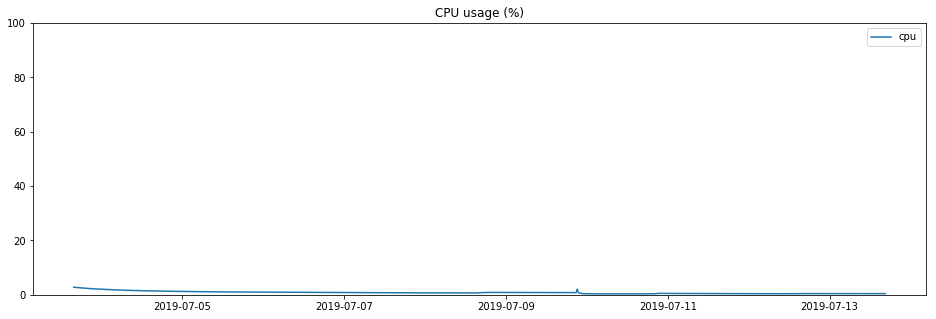

In [4]:
plt.figure(figsize=(16,5))

plt.plot(data['date'], data['cpu'])

plt.ylim([0, 100])
plt.legend()
plt.title("CPU usage (%)")
plt.show()

#### Proccesses

In [5]:
procs = []
for i,r in data.iterrows():
    for p in r['top_proc']:
        p['date'] = r['date']
        procs += [ p ]
procs = pd.DataFrame(procs)[['date', 'user', 'cpu', 'command']]
procs['cpu'] = procs['cpu'].astype(float)

procs.head()


,date,user,cpu,command
0,2019-07-03 15:50:01,root,2.0,[kswapd0]
1,2019-07-03 15:50:01,matterm+,0.9,/opt/mattermost/bin/mattermost
2,2019-07-03 15:50:01,root,0.5,/usr/sbin/samhain
3,2019-07-03 15:50:01,root,0.3,/usr/bin/gcsfuse --foreground -o rw -o allow_o...
4,2019-07-03 16:00:02,root,1.9,[kswapd0]


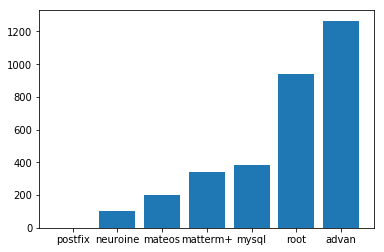

In [6]:
user_sums = procs.groupby('user')['cpu'].sum().sort_values()

plt.bar(user_sums.index, user_sums)
plt.show()

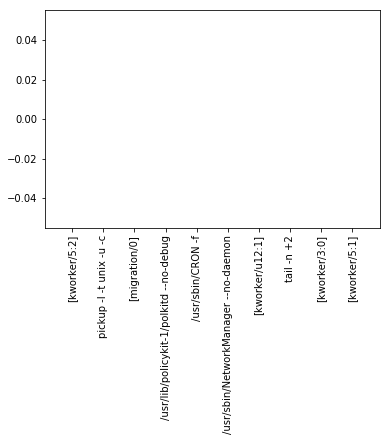

In [8]:
command_sums = procs.groupby('command')['cpu'].sum().sort_values().head(10)
plt.bar(command_sums.index, command_sums)
plt.xticks(rotation=90)
plt.show()

#### MySQL Queries

In [89]:
quers = []

for j,r in data.iterrows():
    for q in r['queries']:
        q['date'] = r['date']
        quers += [ q ]
quers = pd.DataFrame(quers)[['date', 'query', 'time', 'user']]
quers['time'] = quers['time'].astype(int)

display(quers[quers['time'] > 20].sort_values('time', ascending=False))

,date,query,time,user
13,2019-07-06 23:50:02,SELECT /*!40001 SQL_NO_CACHE */ * FROM `stores...,164,advan
14,2019-07-07 23:50:02,SELECT /*!40001 SQL_NO_CACHE */ * FROM `stores...,150,advan
0,2019-07-01 23:50:03,SELECT /*!40001 SQL_NO_CACHE */ * FROM `stores...,113,advan
4,2019-07-03 23:50:01,SELECT /*!40001 SQL_NO_CACHE */ * FROM `stores...,55,advan


In [ ]:
query_time = quers.groupby('query')['time'].max().sort_values().head(10)

#query_time =  quers.sort_values('time', ascending=False)

plt.bar(query_time.index, query_time)
plt.xticks(rotation=90)
plt.show()